In [2]:
from datetime import datetime
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer
from src.utils.dataset_creator import load_dataset, data_array_to_numpy

# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [3]:
train, valid, test = load_dataset(creator=ECG200(),
                                  data_path=Path(api_dir) / "src/datasets/ECG200")

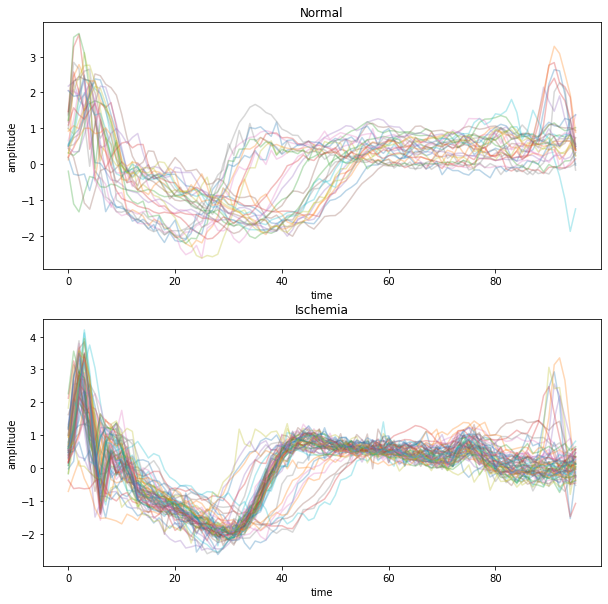

In [4]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
ax[1].set_xlabel("time")
ax[1].set_ylabel("amplitude")
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays. This can be done manually or using the helper function found in the dataset_creator module.

In [5]:
train_numpy, valid_numpy, test_numpy = data_array_to_numpy(train, valid, test)

# Classify heartbeats
To be able to classify the heartbeats a model needs created and to be fitted
## Create model

In [6]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

In [7]:
# define and fit classifier
output_dir = Path(api_dir) / "src/output"/ datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=output_dir, **hp_dict)

## Fitting model
To fit the model to the training set the `.fit_classifier` method is used.

In [8]:
clf.fit_classifier(train_numpy, test_numpy)

Epoch 1/500
6/6 [==============================] - 2s 398ms/step - loss: 0.7084 - tp: 33.0000 - fp: 57.0000 - tn: 33.0000 - fn: 57.0000 - accuracy: 0.3667 - precision: 0.3667 - recall: 0.3667 - auc: 0.3271 - prc: 0.4189 - val_loss: 0.6735 - val_tp: 64.0000 - val_fp: 36.0000 - val_tn: 64.0000 - val_fn: 36.0000 - val_accuracy: 0.6400 - val_precision: 0.6400 - val_recall: 0.6400 - val_auc: 0.7231 - val_prc: 0.7237
Epoch 2/500
6/6 [==============================] - 1s 113ms/step - loss: 0.6995 - tp: 61.0000 - fp: 29.0000 - tn: 61.0000 - fn: 29.0000 - accuracy: 0.6778 - precision: 0.6778 - recall: 0.6778 - auc: 0.6757 - prc: 0.6425 - val_loss: 0.6697 - val_tp: 64.0000 - val_fp: 36.0000 - val_tn: 64.0000 - val_fn: 36.0000 - val_accuracy: 0.6400 - val_precision: 0.6400 - val_recall: 0.6400 - val_auc: 0.7640 - val_prc: 0.7702
Epoch 3/500
6/6 [==============================] - 1s 112ms/step - loss: 0.6901 - tp: 61.0000 - fp: 29.0000 - tn: 61.0000 - fn: 29.0000 - accuracy: 0.6778 - precision: 0.

Epoch 21/500
6/6 [==============================] - 1s 139ms/step - loss: 0.3348 - tp: 78.0000 - fp: 12.0000 - tn: 78.0000 - fn: 12.0000 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9442 - prc: 0.9474 - val_loss: 0.4815 - val_tp: 75.0000 - val_fp: 25.0000 - val_tn: 75.0000 - val_fn: 25.0000 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8613 - val_prc: 0.8542
Epoch 22/500
6/6 [==============================] - 1s 133ms/step - loss: 0.3796 - tp: 74.0000 - fp: 16.0000 - tn: 74.0000 - fn: 16.0000 - accuracy: 0.8222 - precision: 0.8222 - recall: 0.8222 - auc: 0.8970 - prc: 0.9023 - val_loss: 0.4402 - val_tp: 82.0000 - val_fp: 18.0000 - val_tn: 82.0000 - val_fn: 18.0000 - val_accuracy: 0.8200 - val_precision: 0.8200 - val_recall: 0.8200 - val_auc: 0.8838 - val_prc: 0.8782
Epoch 23/500
6/6 [==============================] - 1s 120ms/step - loss: 0.3902 - tp: 69.0000 - fp: 21.0000 - tn: 69.0000 - fn: 21.0000 - accuracy: 0.7667 - precision:

Epoch 41/500
6/6 [==============================] - 1s 102ms/step - loss: 0.2589 - tp: 78.0000 - fp: 12.0000 - tn: 78.0000 - fn: 12.0000 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9585 - prc: 0.9614 - val_loss: 0.4939 - val_tp: 81.0000 - val_fp: 19.0000 - val_tn: 81.0000 - val_fn: 19.0000 - val_accuracy: 0.8100 - val_precision: 0.8100 - val_recall: 0.8100 - val_auc: 0.8994 - val_prc: 0.8900
Epoch 42/500
6/6 [==============================] - 1s 86ms/step - loss: 0.2190 - tp: 81.0000 - fp: 9.0000 - tn: 81.0000 - fn: 9.0000 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9765 - prc: 0.9777 - val_loss: 0.4295 - val_tp: 83.0000 - val_fp: 17.0000 - val_tn: 83.0000 - val_fn: 17.0000 - val_accuracy: 0.8300 - val_precision: 0.8300 - val_recall: 0.8300 - val_auc: 0.9008 - val_prc: 0.8953
Epoch 43/500
6/6 [==============================] - 0s 55ms/step - loss: 0.2099 - tp: 82.0000 - fp: 8.0000 - tn: 82.0000 - fn: 8.0000 - accuracy: 0.9111 - precision: 0.911

Epoch 61/500
6/6 [==============================] - 1s 118ms/step - loss: 0.1793 - tp: 87.0000 - fp: 3.0000 - tn: 87.0000 - fn: 3.0000 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9921 - prc: 0.9924 - val_loss: 0.4552 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9220 - val_prc: 0.9122
Epoch 62/500
6/6 [==============================] - 1s 131ms/step - loss: 0.1206 - tp: 86.0000 - fp: 4.0000 - tn: 86.0000 - fn: 4.0000 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9920 - prc: 0.9923 - val_loss: 0.4400 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9277 - val_prc: 0.9239
Epoch 63/500
6/6 [==============================] - 1s 104ms/step - loss: 0.1219 - tp: 83.0000 - fp: 7.0000 - tn: 83.0000 - fn: 7.0000 - accuracy: 0.9222 - precision: 0.922

Epoch 81/500
6/6 [==============================] - 1s 137ms/step - loss: 0.0491 - tp: 88.0000 - fp: 2.0000 - tn: 88.0000 - fn: 2.0000 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9985 - prc: 0.9985 - val_loss: 0.6186 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9259 - val_prc: 0.9162
Epoch 82/500
6/6 [==============================] - 1s 118ms/step - loss: 0.0569 - tp: 88.0000 - fp: 2.0000 - tn: 88.0000 - fn: 2.0000 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9985 - prc: 0.9985 - val_loss: 0.5690 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9307 - val_prc: 0.9207
Epoch 83/500
6/6 [==============================] - 1s 140ms/step - loss: 0.0437 - tp: 88.0000 - fp: 2.0000 - tn: 88.0000 - fn: 2.0000 - accuracy: 0.9778 - precision: 0.977

Epoch 101/500
6/6 [==============================] - 1s 142ms/step - loss: 0.0368 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9999 - prc: 0.9999 - val_loss: 0.6185 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9310 - val_prc: 0.9214
Epoch 102/500
6/6 [==============================] - 1s 144ms/step - loss: 0.0346 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9999 - prc: 0.9999 - val_loss: 0.6119 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9317 - val_prc: 0.9219
Epoch 103/500
6/6 [==============================] - 1s 142ms/step - loss: 0.0321 - tp: 88.0000 - fp: 2.0000 - tn: 88.0000 - fn: 2.0000 - accuracy: 0.9778 - precision: 0.

Epoch 121/500
6/6 [==============================] - 1s 139ms/step - loss: 0.0145 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7179 - val_tp: 89.0000 - val_fp: 11.0000 - val_tn: 89.0000 - val_fn: 11.0000 - val_accuracy: 0.8900 - val_precision: 0.8900 - val_recall: 0.8900 - val_auc: 0.9332 - val_prc: 0.9240
Epoch 122/500
6/6 [==============================] - 1s 138ms/step - loss: 0.0129 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7542 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9246 - val_prc: 0.9122
Epoch 123/500
6/6 [==============================] - 1s 133ms/step - loss: 0.0146 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy

6/6 [==============================] - 1s 131ms/step - loss: 0.0073 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8492 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9044 - val_prc: 0.8825
Epoch 141/500
6/6 [==============================] - 1s 112ms/step - loss: 0.0086 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7810 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9275 - val_prc: 0.9153
Epoch 142/500
6/6 [==============================] - 1s 101ms/step - loss: 0.0097 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - pre

6/6 [==============================] - 1s 120ms/step - loss: 0.0040 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8924 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9055 - val_prc: 0.8841
Epoch 160/500
6/6 [==============================] - 1s 110ms/step - loss: 0.0042 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8889 - val_tp: 89.0000 - val_fp: 11.0000 - val_tn: 89.0000 - val_fn: 11.0000 - val_accuracy: 0.8900 - val_precision: 0.8900 - val_recall: 0.8900 - val_auc: 0.9061 - val_prc: 0.8847
Epoch 161/500
6/6 [==============================] - 1s 119ms/step - loss: 0.0037 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - pre

6/6 [==============================] - 1s 112ms/step - loss: 0.0025 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9301 - val_tp: 89.0000 - val_fp: 11.0000 - val_tn: 89.0000 - val_fn: 11.0000 - val_accuracy: 0.8900 - val_precision: 0.8900 - val_recall: 0.8900 - val_auc: 0.9065 - val_prc: 0.8850
Epoch 179/500
6/6 [==============================] - 1s 116ms/step - loss: 0.0024 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9526 - val_tp: 89.0000 - val_fp: 11.0000 - val_tn: 89.0000 - val_fn: 11.0000 - val_accuracy: 0.8900 - val_precision: 0.8900 - val_recall: 0.8900 - val_auc: 0.9059 - val_prc: 0.8845
Epoch 180/500
6/6 [==============================] - 1s 139ms/step - loss: 0.0024 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - pre

6/6 [==============================] - 1s 101ms/step - loss: 0.0021 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9911 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9066 - val_prc: 0.8854
Epoch 198/500
6/6 [==============================] - 1s 87ms/step - loss: 0.0017 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9709 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9068 - val_prc: 0.8856
Epoch 199/500
6/6 [==============================] - 1s 103ms/step - loss: 0.0019 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - prec

6/6 [==============================] - 1s 102ms/step - loss: 0.0013 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0457 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9071 - val_prc: 0.8862
Epoch 217/500
6/6 [==============================] - 1s 122ms/step - loss: 0.0011 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0205 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.8989 - val_prc: 0.8752
Epoch 218/500
6/6 [==============================] - 1s 103ms/step - loss: 0.0014 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - pre

6/6 [==============================] - 1s 103ms/step - loss: 9.4753e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0612 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9001 - val_prc: 0.8766
Epoch 236/500
6/6 [==============================] - 1s 114ms/step - loss: 9.8854e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0587 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9011 - val_prc: 0.8779
Epoch 237/500
6/6 [==============================] - 1s 101ms/step - loss: 0.0010 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.00

6/6 [==============================] - 1s 136ms/step - loss: 6.5149e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1091 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.8999 - val_prc: 0.8765
Epoch 255/500
6/6 [==============================] - 1s 121ms/step - loss: 7.6606e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1206 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9001 - val_prc: 0.8766
Epoch 256/500
6/6 [==============================] - 1s 120ms/step - loss: 7.1950e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 120ms/step - loss: 6.1599e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1301 - val_tp: 88.0000 - val_fp: 12.0000 - val_tn: 88.0000 - val_fn: 12.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9007 - val_prc: 0.8775
Epoch 274/500
6/6 [==============================] - 1s 142ms/step - loss: 5.1861e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1403 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9007 - val_prc: 0.8775
Epoch 275/500
6/6 [==============================] - 1s 134ms/step - loss: 5.4512e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 120ms/step - loss: 4.3844e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1607 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9010 - val_prc: 0.8778
Epoch 293/500
6/6 [==============================] - 1s 127ms/step - loss: 4.1775e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1634 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9010 - val_prc: 0.8778
Epoch 294/500
6/6 [==============================] - 1s 117ms/step - loss: 4.2654e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 122ms/step - loss: 3.5372e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1897 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9019 - val_prc: 0.8789
Epoch 312/500
6/6 [==============================] - 1s 117ms/step - loss: 3.4973e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1931 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9010 - val_prc: 0.8778
Epoch 313/500
6/6 [==============================] - 1s 142ms/step - loss: 3.4533e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 119ms/step - loss: 3.0717e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2024 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8943 - val_prc: 0.8690
Epoch 331/500
6/6 [==============================] - 1s 143ms/step - loss: 2.8647e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2132 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9018 - val_prc: 0.8788
Epoch 332/500
6/6 [==============================] - 1s 136ms/step - loss: 2.8252e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 115ms/step - loss: 2.4105e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2398 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8941 - val_prc: 0.8689
Epoch 350/500
6/6 [==============================] - 1s 128ms/step - loss: 2.4064e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2366 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8941 - val_prc: 0.8689
Epoch 351/500
6/6 [==============================] - 1s 122ms/step - loss: 2.3757e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 126ms/step - loss: 2.0137e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2569 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8941 - val_prc: 0.8689
Epoch 369/500
6/6 [==============================] - 1s 116ms/step - loss: 2.0689e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2526 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8942 - val_prc: 0.8689
Epoch 370/500
6/6 [==============================] - 1s 112ms/step - loss: 1.9914e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 104ms/step - loss: 1.7323e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2778 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8951 - val_prc: 0.8701
Epoch 388/500
6/6 [==============================] - 1s 112ms/step - loss: 1.6870e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2832 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8950 - val_prc: 0.8700
Epoch 389/500
6/6 [==============================] - 1s 97ms/step - loss: 1.6994e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1

6/6 [==============================] - 1s 126ms/step - loss: 1.5183e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2898 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 407/500
6/6 [==============================] - 1s 125ms/step - loss: 1.5163e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2895 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 408/500
6/6 [==============================] - 1s 112ms/step - loss: 1.5098e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 99ms/step - loss: 1.4221e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3045 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8950 - val_prc: 0.8700
Epoch 426/500
6/6 [==============================] - 1s 103ms/step - loss: 1.4030e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3018 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 427/500
6/6 [==============================] - 1s 92ms/step - loss: 1.3830e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.

6/6 [==============================] - 1s 126ms/step - loss: 1.2744e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3152 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8951 - val_prc: 0.8701
Epoch 445/500
6/6 [==============================] - 1s 113ms/step - loss: 1.2695e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3130 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 446/500
6/6 [==============================] - 1s 127ms/step - loss: 1.2693e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 104ms/step - loss: 1.1803e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3243 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 464/500
6/6 [==============================] - 1s 125ms/step - loss: 1.1601e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3226 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 465/500
6/6 [==============================] - 1s 103ms/step - loss: 1.1786e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 

6/6 [==============================] - 1s 113ms/step - loss: 1.1137e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3280 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8952 - val_prc: 0.8702
Epoch 483/500
6/6 [==============================] - 1s 87ms/step - loss: 1.1212e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3257 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8961 - val_prc: 0.8713
Epoch 484/500
6/6 [==============================] - 1s 98ms/step - loss: 1.1140e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.

## Classification and evaluation
After training the network its possible to use the model on new data.
To apply the model on some data the `model.predict` method is used.
It is also possible to evaluate model performance using `model.evaluate`.

In [9]:
# make classification
y_pred = clf.model.predict(x=test_numpy.X)

In [10]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 22ms/step - loss: 1.3317 - tp: 87.0000 - fp: 13.0000 - tn: 87.0000 - fn: 13.0000 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.8961 - prc: 0.8713


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.331718,87.0,13.0,87.0,13.0,0.87,0.87,0.87,0.8961,0.871332


# Explain classification
It might also be of interest, to get insight on what the network based its classification on.
Here we can use an explainer such as the SHAP gradient explainer.

In [11]:
is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

Using TensorFlow backend.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
The overlay color is determined by the shap value.

In [12]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_xlabel("amplitude")
    ax.set_title("Explanations of Classifications")
    ax.legend(["Mean normal","Mean ischemia"])

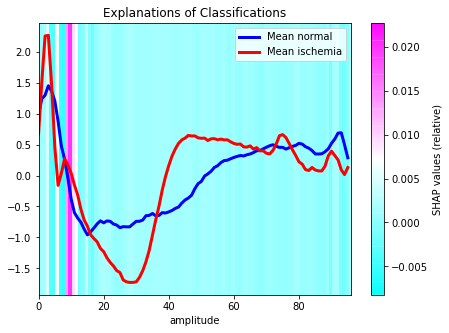

In [13]:
plot_importance(X_to_explain = test_numpy.X, y_pred = y_pred, explanation = ex_classification)